## Setup

In [1]:
from collections import defaultdict, Counter
from dotenv import load_dotenv
from gensim.models import FastText
from gensim.utils import simple_preprocess
import json
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
from sklearn.manifold import TSNE
from tqdm import tqdm

In [2]:
# this is needed, cause notebooks not on same level as helpers
sys.path.insert(0, os.path.abspath(".."))  # assumes notebook is in {root}/notebooks/{fname}.ipynb

# autoreload imports within same session when rerunning cell
%load_ext autoreload

%autoreload 2
from helpers.data_fetchers import fetch_sl_stopwords
from helpers.nlp import read_corpus, \
        get_similar_words_fasttext, \
        get_topn_neighbors, jaccard, \
        generate_seed_words_from_stem, \
        fasttext_incr_train_and_predict, \
        compute_epochwise_jaccard_similarity

## Constants

In [5]:
load_dotenv()

CORPUS_INDEX_ID = os.getenv("CORPUS_INDEX_ID")
CORPUS_INDEX_SHEET = os.getenv("CORPUS_INDEX_SHEET")
ORIG_CORPUS_DIR = os.getenv("ORIG_CORPUS_DIR")
LEMMA_CORPUS_DIR = os.getenv("LEMMATIZED_CORPUS_DIR")
NUM_CPUS = multiprocessing.cpu_count()

# correct constants for calling within notebook
MAIN_ORIGINAL = '../' + ORIG_CORPUS_DIR + 'sentence'
MAIN_LEMMA = '../' + LEMMA_CORPUS_DIR + 'sentence'
PAR_ORG = '../' + ORIG_CORPUS_DIR + 'paragraph'
PAR_LEM = '../' + LEMMA_CORPUS_DIR + 'paragraph'

## Data prep

In [4]:
df = pd.read_csv('../corpus_metadata.csv')
df.head()

,shame_id,author_and_title,original_id,author,author_fname,author_lname,author_gender,title,word_count,publ_year,publ_year_clean,doc_link,source_corpus,comment
0,SHAME_1,Albin Prepeluh-Mina,KDSP199,Albin Prepeluh,Albin,Prepeluh,M,Mina,33063,1910.0,1910.0,https://github.com/COST-ELTeC/ELTeC-slv/blob/v...,KDSP,NaN
1,SHAME_2,Alojz Kraigher-Kontrolor Škrobar,KDSP234,Alojz Kraigher,Alojz,Kraigher,M,Kontrolor Škrobar,130090,1914.0,1914.0,https://www.dlib.si/details/URN:NBN:SI:DOC-KCB...,KDSP,NaN
2,SHAME_3,Alojz Kraigher-Mlada ljubezen,KDSP254,Alojz Kraigher,Alojz,Kraigher,M,Mlada ljubezen,75260,1917.0,1917.0,https://github.com/COST-ELTeC/ELTeC-slv/blob/v...,KDSP,NaN
3,SHAME_4,Alojz Kraigher-Peter Drozeg,NaN,Alojz Kraigher,Alojz,Kraigher,M,Peter Drozeg,20324,1916.0,1916.0,https://lit.ijs.si/kraigher.html,Wikivir - leposlovje,NaN
4,SHAME_5,Alojzij Kokalj-Cerkvene miši,KDSP227,Alojzij Kokalj,Alojzij,Kokalj,M,Cerkvene miši,86058,1913.0,1913.0,https://sl.wikisource.org/wiki/Cerkvene_mi%C5%A1i,KDSP,NaN


## One-time FastText training to see results

In [6]:
# Convert generator to list for training (if your corpus is not huge)
sentences_orig = list(read_corpus(MAIN_ORIGINAL))
sentences_lemma = list(read_corpus(MAIN_LEMMA))

# different num of sentences, cause Wikivir wasn't lemmatized
len(sentences_orig), len(sentences_lemma)

(913948, 862173)

In [7]:
# Create a list of seed words based on the root lemma "sram" to be used
# in training
flat_words = [word for sent in sentences_lemma for word in sent]
word_counts = Counter(flat_words)
matches = [w for w in word_counts if 'sram' in w]  # crude stem match

# manually inspected the list below and generated the excluded words
non_shame_words = ['nesramnost', 'narnesramen', 'nasramen', 'nesramen',
                   'nesramno']

seed_words = []
for m in sorted(matches): 
    if m not in non_shame_words:
        # uncomment to print
        #print(m)
        seed_words.append(m)

In [8]:
# check how often seed words appear in lemma
flat_words = [word for sent in sentences_lemma for word in sent]
word_counts = Counter(flat_words)

# Create a list of tuples: (word, count)
seed_counts = [(w, word_counts.get(w, 0)) for w in seed_words]

# Sort by count (descending)
seed_counts_sorted = sorted(seed_counts, key=lambda x: x[1], reverse=True)

for w, count in seed_counts_sorted:
    print(w, count)

sram 1279
sramota 1236
sramovati 695
sramoten 246
sramezljivo 228
osramocen 162
sramezljivost 139
sramezljiv 120
sramotno 102
osramotiti 99
nesramnez 76
sramotiti 69
zasramovati 57
sramozljivost 32
nesramnica 28
zasramovanje 26
osramocenje 24
sramotilen 19
sramotenje 12
sramozljiv 12
sramovanje 8
sramu 8
zasramovan 8
sramujoc 7
brezsramno 5
osramoten 5
sramocenje 5
zasramovalec 5
brezsramen 4
sramotilec 4
sramozljivo 4
nesramozljiv 3
osramocenost 3
presramoten 3
sramocen 3
zasramljivo 3
brezsramnik 2
nesramnezev 2
nesramnik 2
osramljen 2
osramotjen 2
presramotno 2
sramez 2
sramot 2
sramote 2
sramotec 2
sramovaje 2
zasramba 2
zasramovalen 2
krvosramen 1
krvosramstvo 1
nesramezljivo 1
nesramezljivost 1
nesramnej 1
nesramnes 1
nesramnosla 1
nesramoten 1
osramocenov 1
osramocevati 1
osramotenje 1
osramoteti 1
osramotivsiti 1
osramovati 1
presramezljiv 1
presramozljiv 1
sramec 1
sramezjiv 1
sramiti 1
sramoti 1
sramotilka 1
sramotivec 1
sramotljiv 1
sramuje 1
sramvati 1
zasramljiv 1
zasramnj

In [9]:
# Filter counts to only seed words with more than 50 appearances
common_seed_words = [w for w, c in seed_counts_sorted if c >= 50]

common_seed_words

['sram',
 'sramota',
 'sramovati',
 'sramoten',
 'sramezljivo',
 'osramocen',
 'sramezljivost',
 'sramezljiv',
 'sramotno',
 'osramotiti',
 'nesramnez',
 'sramotiti',
 'zasramovati']

In [10]:
# use help funct for seed words, made after teh analysis above
sw_loc = '../output/seed_words.txt'
seed_words = generate_seed_words_from_stem(
    stem="sram", corpus_path="../data/lemma_txt_corpus/sentence",
    n=50, out_path=sw_loc)

seed_words = [x for x, _ in seed_words]
seed_words

['sram',
 'sramota',
 'sramovati',
 'sramoten',
 'sramezljivo',
 'sramezljivost',
 'sramezljiv',
 'sramotno',
 'sramotiti']

In [ ]:
# train FastText embeddings
model = FastText(
    sentences=sentences_lemma,
    vector_size=300,   # embedding size
    window=5,
    min_count=1,
    workers=NUM_CPUS,
    sg=1,              # 1 = skip-gram; better for semantic similarity
    epochs=5
)

In [11]:
# find similar words
similarity_data = get_similar_words_fasttext(model, seed_words, topn=100)

df_sim_words = pd.DataFrame(similarity_data)
#pd.set_option('display.max_rows', None)
pd.reset_option('^display.', silent=True)

df_sim_words

,seed,similar,similarity
0,sram,sramu,0.901838
1,sram,sramuje,0.840859
2,sram,sramec,0.795024
3,sram,sramovaje,0.770062
4,sram,sramez,0.761216
...,...,...,...
895,sramotiti,smotiti,0.689019
896,sramotiti,krvjiti,0.688621
897,sramotiti,umesiti,0.688370
898,sramotiti,preklicevati,0.688009


In [ ]:
# save similar words
os.makedirs("../output", exist_ok=True)
df_sim_words.to_csv("../output/shame_similar_words.csv", index=False)

# save model
os.makedirs("../models", exist_ok=True)
model.save("../models/fasttext_lemma_5ep.model")

## Continuously train for n epochs > predict at each epoch batch

🚀 Model not found at ../models/ft_300ep_lemma_txt_sentence_remove_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [56:30<00:00, 56.51s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_lemma_txt_sentence_remove_stopwords.json
✅ Model saved to ../models/ft_300ep_lemma_txt_sentence_remove_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_lemma_txt_sentence_remove_stopwords.csv
🚀 Model not found at ../models/ft_300ep_original_txt_sentence_remove_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:24:00<00:00, 84.02s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_original_txt_sentence_remove_stopwords.json
✅ Model saved to ../models/ft_300ep_original_txt_sentence_remove_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_original_txt_sentence_remove_stopwords.csv
🚀 Model not found at ../models/ft_300ep_lemma_txt_sentence_keep_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:15:42<00:00, 75.71s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_lemma_txt_sentence_keep_stopwords.json
✅ Model saved to ../models/ft_300ep_lemma_txt_sentence_keep_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_lemma_txt_sentence_keep_stopwords.csv
🚀 Model not found at ../models/ft_300ep_original_txt_sentence_keep_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:52:04<00:00, 112.08s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_original_txt_sentence_keep_stopwords.json
✅ Model saved to ../models/ft_300ep_original_txt_sentence_keep_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_original_txt_sentence_keep_stopwords.csv
🚀 Model not found at ../models/ft_300ep_lemma_txt_paragraph_remove_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:14:26<00:00, 74.45s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_lemma_txt_paragraph_remove_stopwords.json
✅ Model saved to ../models/ft_300ep_lemma_txt_paragraph_remove_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_lemma_txt_paragraph_remove_stopwords.csv
🚀 Model not found at ../models/ft_300ep_original_txt_paragraph_remove_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:44:51<00:00, 104.86s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_original_txt_paragraph_remove_stopwords.json
✅ Model saved to ../models/ft_300ep_original_txt_paragraph_remove_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_original_txt_paragraph_remove_stopwords.csv
🚀 Model not found at ../models/ft_300ep_lemma_txt_paragraph_keep_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [1:36:23<00:00, 96.40s/it]


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_lemma_txt_paragraph_keep_stopwords.json
✅ Model saved to ../models/ft_300ep_lemma_txt_paragraph_keep_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_lemma_txt_paragraph_keep_stopwords.csv
🚀 Model not found at ../models/ft_300ep_original_txt_paragraph_keep_stopwords, training new one...
🔧 Initializing FastText model…
🚀 Starting incremental training:


Epochs: 100%|██████████| 60/60 [2:18:39<00:00, 138.65s/it]  


✅ Neighbors saved to ../output/neighbors_by_epoch_ft_300ep_original_txt_paragraph_keep_stopwords.json
✅ Model saved to ../models/ft_300ep_original_txt_paragraph_keep_stopwords
✅ Jaccard similarity CSV saved to: ../output/ep_jaccard_sim_original_txt_paragraph_keep_stopwords.csv


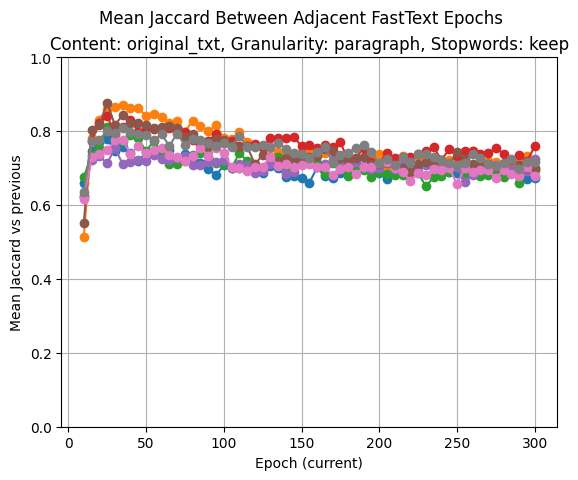

In [19]:
# ─── Configuration ──────────────────────────────────────────────────
stopwords = fetch_sl_stopwords('../data/stopwords_sl.txt')
st_treatment = {'remove_stopwords': stopwords, 'keep_stopwords': None}
step_epochs = 5
max_epochs = 300
topn = 100
NUM_CPUS = multiprocessing.cpu_count()

# ─── Prepare Corpus ─────────────────────────────────────────────────

#sentences_orig = list(read_corpus(MAIN_ORIGINAL, stopwords))
#sentences_lemma = list(read_corpus(MAIN_LEMMA, stopwords))

# ─── Train FastText model ───────────────────────────────────────────

model_name = "ft_300ep_"
model_dir = "../models"
model_path = os.path.join(model_dir, model_name)

# compute all possibilities:
for granularity in ['sentence', 'paragraph']:
    for st_choice in st_treatment.keys():
        for content_type in ['lemma_txt', 'original_txt']:
            model_name = f"ft_300ep_{content_type}_{granularity}_{st_choice}"
            model_dir = "../models"
            model_path = os.path.join(model_dir, model_name)
            _stopwords = st_treatment[st_choice]
            input_dir = f'../data/{content_type}_corpus/{granularity}'
            output_json_dir = '../output'
            output_json_fname = f"neighbors_by_epoch_ft_300ep_{content_type}_{granularity}_{st_choice}.json"
            output_json_path = os.path.join(output_json_dir, output_json_fname)


            if os.path.exists(model_path):
                print(f"✅ Loading existing model from: {model_path}")
                ft_model = FastText.load(model_path)
            else:
                print(f"🚀 Model not found at {model_path}, training new one...")

                sentences = list(read_corpus(input_dir, _stopwords))
                
                ft_model = fasttext_incr_train_and_predict(
                    sentences=sentences,
                    seed_words=seed_words,
                    output_json_fname=output_json_fname,
                    output_json_dir=output_json_dir,
                    output_model_fname=model_name,
                    output_model_dir=model_dir,
                    workers=NUM_CPUS,
                    max_epochs=max_epochs,
                    step_epochs=step_epochs,
                    topn=topn
                    )
            
            # compute stability in mean Jaccardian similarity between consecutive epochs
            stability_df = compute_epochwise_jaccard_similarity(
                neighbor_json_path=output_json_path,
                seed_words=seed_words,
                output_csv_path=f"../output/ep_jaccard_sim_{content_type}_{granularity}_{st_choice}.csv"
            )

            # save plot for visual inspection
            plt.plot(stability_df["curr_epoch"], 
                     stability_df["mean_jaccard"], 
                     marker='o')
            plt.suptitle("Mean Jaccard Between Adjacent FastText Epochs")
            plt.title(f"Content: {content_type}, Granularity: {granularity}, Stopwords: {st_choice.split('_')[0]}")
            plt.xlabel("Epoch (current)")
            plt.ylabel("Mean Jaccard vs previous")
            plt.grid(True)
            plt.ylim(0, 1)
            plt.savefig(f"../output/jaccard_curve_ft_{content_type}_{granularity}_{st_choice}.png")



In [16]:
stability_df.head()

""
